In [1]:
library(Seurat)
library(kBET)
library(data.table)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix


In [2]:
# ctrl.data <- read.table("immune_control_expression_matrix.txt.gz", sep = "\t")
# stim.data <- read.table("immune_stimulated_expression_matrix.txt.gz", sep = "\t")

In [3]:
data <- read.table("../pbmc_eq_ct.csv", header = TRUE, sep = ",")

In [4]:
labels <- read.table("../pbmc_eq_ct_batch_labels.csv", header = TRUE, sep = ",")
print(dim(labels))

[1] 8016    2


In [5]:
ctrl.data <- data[labels$batch_cov == 0, 1:ncol(data)]
stim.data <- data[labels$batch_cov == 1, 1:ncol(data)]

In [6]:
print(dim(ctrl.data))
print(dim(stim.data))

[1] 4008 3346
[1] 4008 3346


In [7]:
ctrl.data <- t(ctrl.data)
stim.data <- t(stim.data)

In [8]:
dim(ctrl.data)

[1] 3346 4008

In [9]:
# Set up control object
ctrl <- CreateSeuratObject(raw.data = ctrl.data, project = "IMMUNE_CTRL", min.cells = 5)
ctrl@meta.data$stim <- "CTRL"
ctrl <- FilterCells(ctrl, subset.names = "nGene", low.thresholds = 500, high.thresholds = Inf)
ctrl <- NormalizeData(ctrl)
ctrl <- ScaleData(ctrl)
# Set up stimulated object
stim <- CreateSeuratObject(raw.data = stim.data, project = "IMMUNE_STIM", min.cells = 5)
stim@meta.data$stim <- "STIM"
stim <- FilterCells(stim, subset.names = "nGene", low.thresholds = 500, high.thresholds = Inf)
stim <- NormalizeData(stim)
stim <- ScaleData(stim)

Scaling data matrix
Scaling data matrix


In [10]:
# Gene selection for input to CCA
ctrl <- FindVariableGenes(ctrl, do.plot = F)
stim <- FindVariableGenes(stim, do.plot = F)
g.1 <- head(rownames(ctrl@hvg.info), 1000)
g.2 <- head(rownames(stim@hvg.info), 1000)
genes.use <- unique(c(g.1,g.2))
genes.use <- intersect(genes.use, rownames(ctrl@scale.data))
genes.use <- intersect(genes.use, rownames(stim@scale.data))

In [11]:
print(length(genes.use))

[1] 1275


In [12]:
# Run CCA
immune.combined <- RunCCA(ctrl, stim, genes.use = genes.use, num.cc = 30)

Scaling data matrix


Scaling data matrix
Scaling data matrix


  |======================================================================| 100%


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


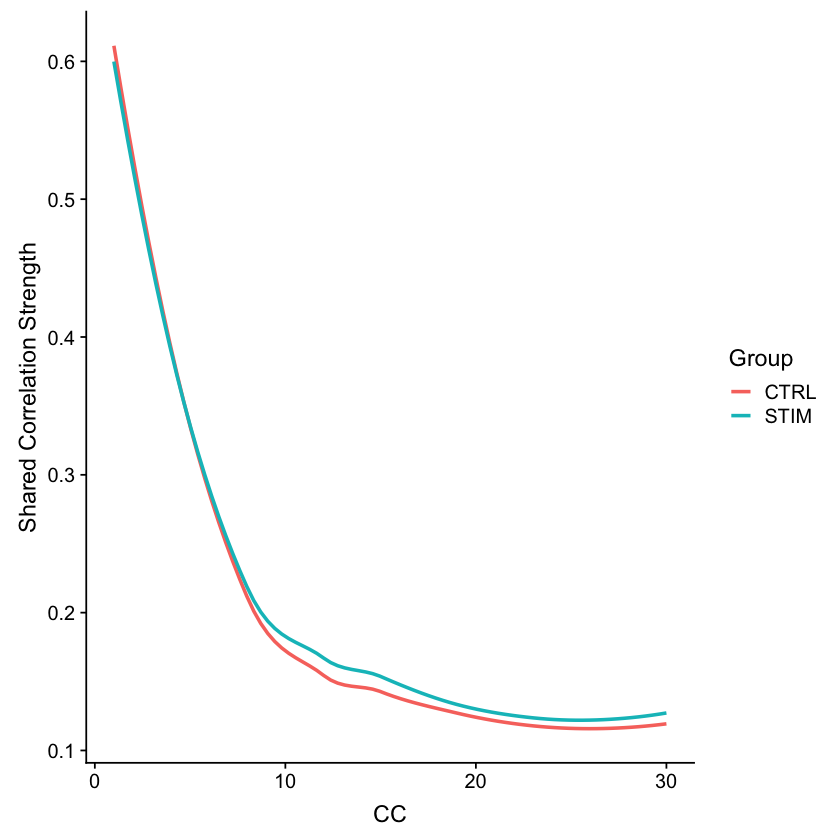

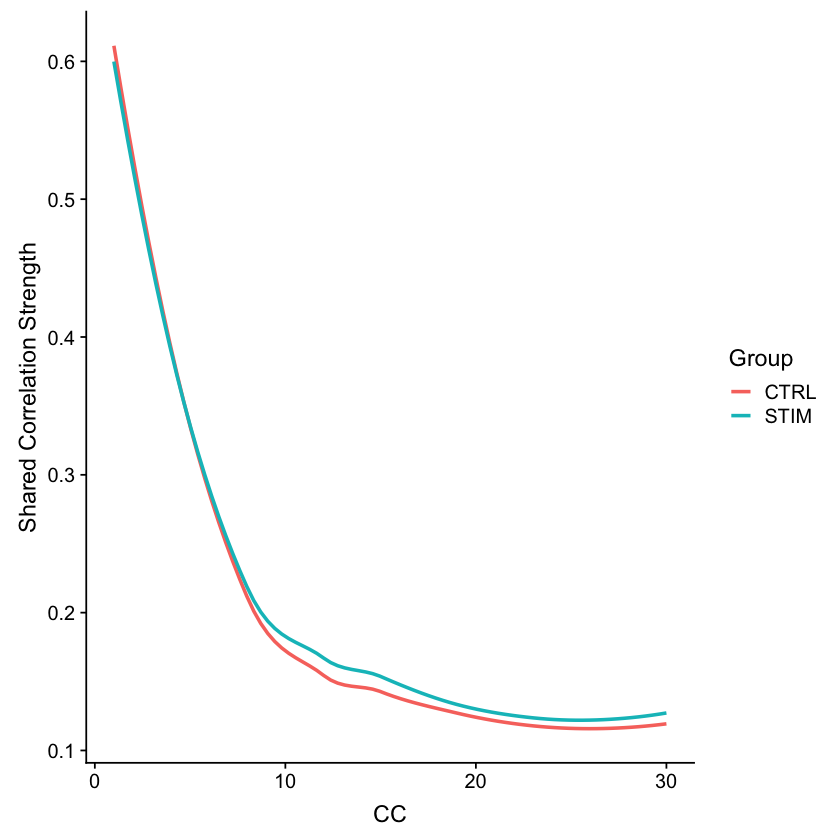

In [13]:
# CC Selection
MetageneBicorPlot(immune.combined, grouping.var = "stim", dims.eval = 1:30)

In [14]:
# Run rare non-overlapping filtering (no cells detected here as expected)
immune.combined <- CalcVarExpRatio(immune.combined, reduction.type = "pca", grouping.var = "orig.ident", dims.use = 1:20)

In [15]:
# Alignment
immune.combined <- AlignSubspace(immune.combined, reduction.type = "cca", grouping.var = "orig.ident", dims.align = 1:20)

Scaling data matrix
Scaling data matrix


In [16]:
# https://github.com/satijalab/seurat/blob/65b77a9480281ef9ab1aa8816f7c781752092c18/R/alignment.R#L299
alignment.score <- CalcAlignmentMetric(immune.combined, reduction.use = "cca.aligned",
                    dims.use = 1:20, grouping.var = "orig.ident")
sprintf("alignment score: %f", alignment.score)

[1] "alignment score: 0.941330"

In [17]:
immune.combined <- RunTSNE(immune.combined, reduction.use = "cca.aligned", dims.use = 1:20, 
    do.fast = T)
immune.combined <- FindClusters(immune.combined, reduction.type = "cca.aligned", 
    resolution = 0.6, dims.use = 1:20)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1983
Number of edges: 122044

Running Louvain algorithm...
Random start: 1
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8379
Iteration: 3
Modularity: 0.8379

Random start: 2
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8380
Iteration: 3
Modularity: 0.8380

Random start: 3
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8380
Iteration: 3
Modularity: 0.8380

Random start: 4
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8379
Iteration: 3
Modularity: 0.8379

Random start: 5
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8380
Iteration: 3
Modularity: 0.8380

Random start: 6
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8379
Iteration: 3
Modularity: 0.8379

Random start: 7
Iteration: 1
Modularity: 0.8377
Iteration: 2
Modularity: 0.8380
Iteration: 3
Modularity: 0.8380

Random start: 8
Iteration: 1
Modularity: 0.8377
Iteration: 2

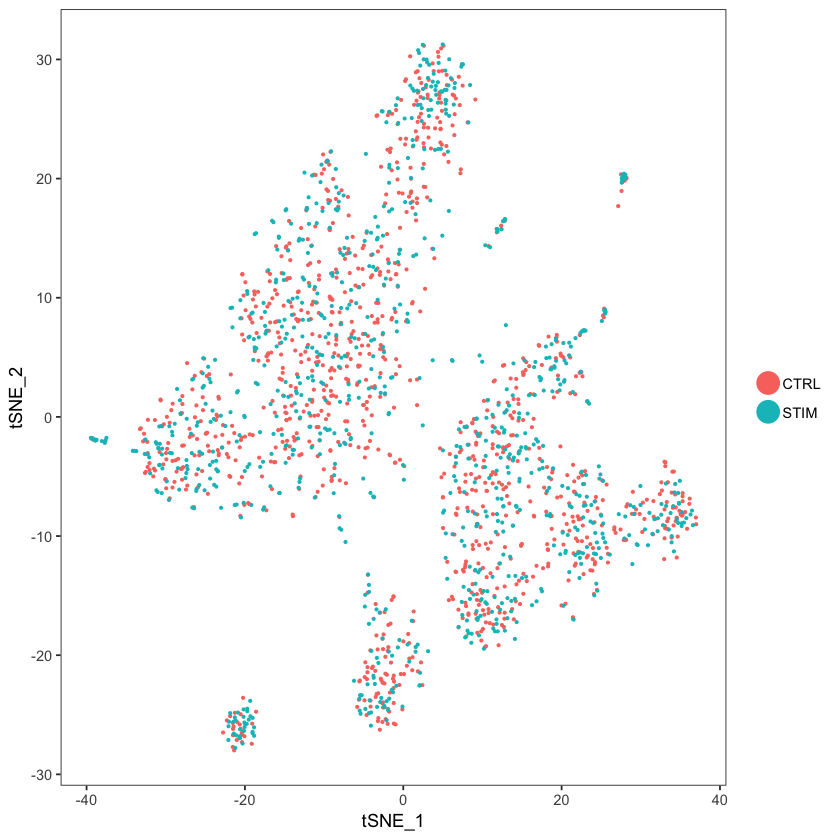

In [18]:
p1 <- TSNEPlot(immune.combined, do.return = T, pt.size = 0.5, group.by = "stim")
plot(p1)

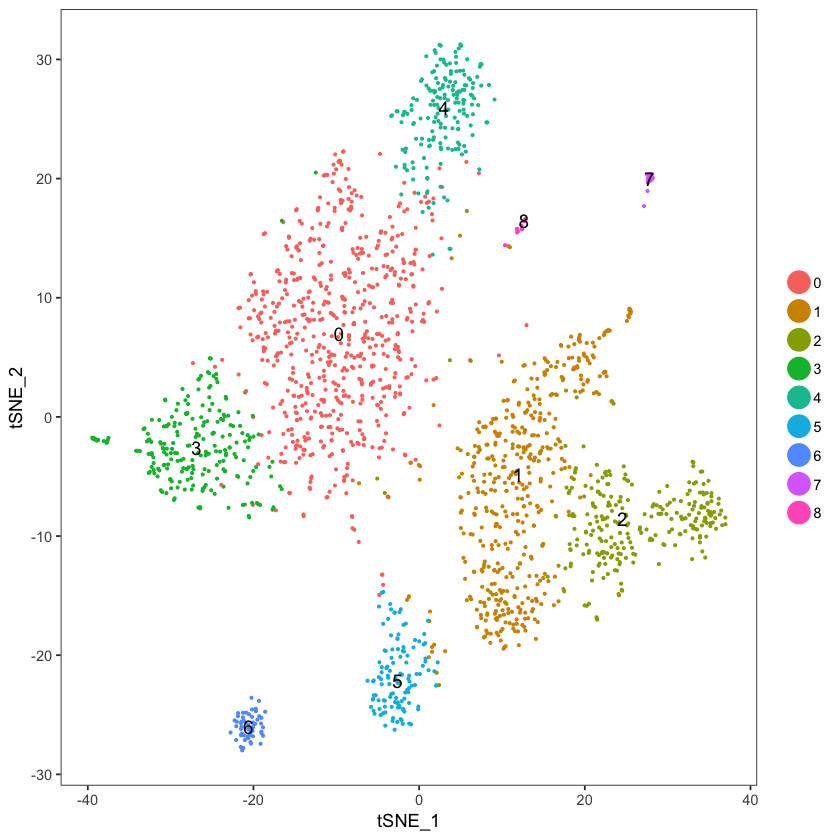

In [19]:
p2 <- TSNEPlot(immune.combined, do.label = T, do.return = T, pt.size = 0.5)
plot(p2)

In [20]:
# get projection of cells onto low-dim space
d <- GetCellEmbeddings(object = immune.combined, reduction.type = "cca")

In [21]:
batch_labels <- immune.combined@meta.data$orig.ident

In [28]:
table(batch_labels)

batch_labels
IMMUNE_CTRL IMMUNE_STIM 
       1091         892 

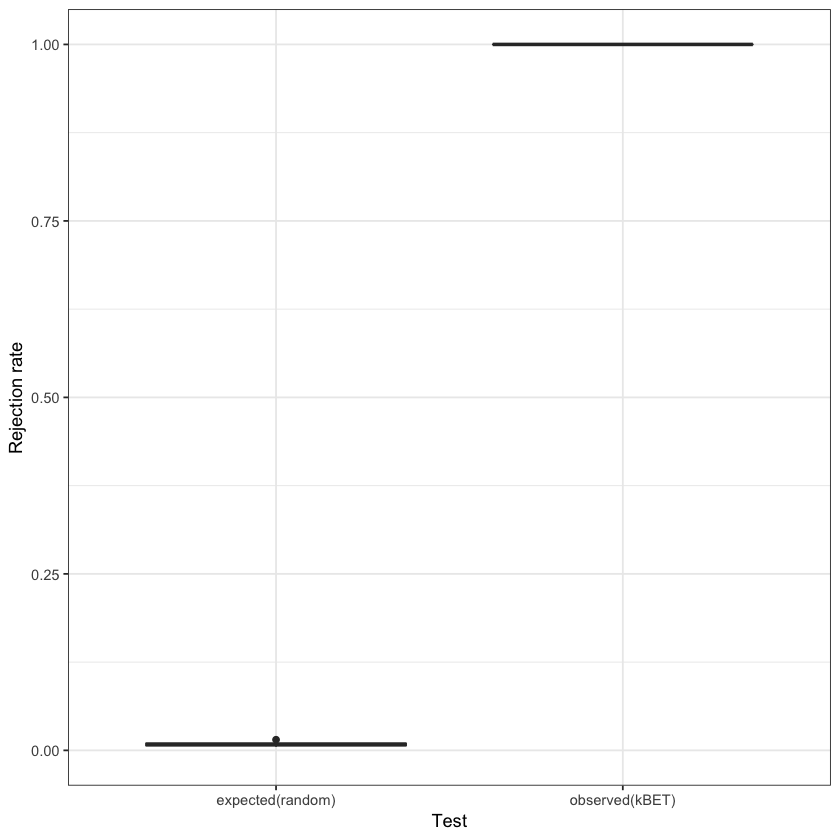

In [22]:
batch.estimate <- kBET(d, batch_labels, do.pca=FALSE, n_repeat=20)

In [23]:
batch.estimate

$summary
      kBET.expected kBET.observed kBET.signif
mean    0.008542714             1           0
2.5%    0.005025126             1           0
50%     0.008375209             1           0
97.5%   0.014279732             1           0

$results
     tested kBET.pvalue.test kBET.pvalue.null
1         1     1.901062e-08        0.5266519
2         1     2.188250e-12        0.6486050
3         1     3.289566e-10        0.5457997
4         1     7.732537e-11        0.5312413
5         1     7.732537e-11        0.4407717
6         1     2.239159e-07        0.5932657
7         1     8.371082e-14        0.8207429
8         1     5.157555e-09        0.4099869
9         1     4.417775e-08        0.6005388
10        1     6.223355e-12        0.4209559
11        1     5.157555e-09        0.5956994
12        1     1.237217e-08        0.6823958
13        1     8.009316e-09        0.5167732
14        1     8.009316e-09        0.6199909
15        1     1.237217e-08        0.5953895
16        1    

In [24]:
# # t-SNE and Clustering
# immune.combined <- RunTSNE(immune.combined, reduction.use = "cca.aligned", dims.use = 1:20, do.fast = T)
# immune.combined <- FindClusters(immune.combined, reduction.type = "cca.aligned", resolution = 0.6,
#                                 dims.use = 1:20, k.param = 30, save.SNN = T, algorithm = 3, force.recalc = TRUE)
# 
# # Visualization
# TSNEPlot(immune.combined, do.label = T)